In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from functions import *
import pickle

In [2]:
training_data_path = "../data/image_data/training_data/"    # define UCF-101 RGB data path
validation_data_path = "../data/image_data/validation_data/"
test_data_path = "../data/image_data/test_data/"
save_model_path = "./3CNN_ckpt/"

# 3D CNN parameters
fc_hidden1, fc_hidden2 = 256, 256
dropout = 0.25       # dropout probability

# training parameters
k = 6            # number of target category
epochs = 15
batch_size = 8
learning_rate = 1e-5
log_interval = 100
img_x, img_y = 256, 342  # resize video 2d frame size

# Select which frame to begin & end in videos
begin_frame, end_frame, skip_frame = 1, 10, 1

In [3]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    model.train()

    losses = []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device)

        N_count += X.size(0)

        optimizer.zero_grad()
        output = model(X)  # output size = (batch, number of classes)

        criterion = nn.L1Loss()
        loss = criterion(output, y)
        losses.append(loss.item())


        loss.backward()
        optimizer.step()

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item()))

    return losses

In [4]:
def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    model.eval()

    test_loss = 0
    all_y = []
    losses = []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device)

            output = model(X)
            criterion = nn.MSELoss()
            loss = torch.sqrt(criterion(output, y))
            losses.append(loss.item()) 
            
            test_loss += loss# sum up batch loss
            all_y.extend(y)

    test_loss /= len(test_loader.dataset)

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.8f},\n'.format(len(all_y), test_loss))

    # save Pytorch models of best record
    torch.save(model.state_dict(), os.path.join(save_model_path, '3dcnn_epoch{}.pth'.format(epoch + 1)))  # save spatial_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, '3dcnn_optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))

    return test_loss

In [5]:
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

In [6]:
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 0, 'pin_memory': True} if use_cuda else {}
params2 = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 0, 'pin_memory': True} if use_cuda else {}

In [7]:
transform = transforms.Compose([transforms.Resize([img_x, img_y]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])])

selected_frames = np.arange(begin_frame, end_frame, skip_frame).tolist()

In [8]:
with open('../data/image_data/pickle_files/y_5d_training_all.pkl', 'rb') as file:
    train_label = pickle.load(file)

with open('../data/image_data/pickle_files/vid_ids_5d_training.pkl', 'rb') as file:
    train_list = pickle.load(file)
    
with open('../data/image_data/pickle_files/y_5d_validation_all.pkl', 'rb') as file:
    val_label = pickle.load(file)

with open('../data/image_data/pickle_files/vid_ids_5d_validation.pkl', 'rb') as file:
    val_list = pickle.load(file)
    
with open('../data/image_data/pickle_files/y_5d_test_all.pkl', 'rb') as file:
    test_label = pickle.load(file)

with open('../data/image_data/pickle_files/vid_ids_5d_test.pkl', 'rb') as file:
    test_list = pickle.load(file)

In [9]:
train_set, valid_set = Dataset_3DCNN(training_data_path, train_list, train_label, selected_frames, transform=transform), \
                       Dataset_3DCNN(validation_data_path, val_list, val_label, selected_frames, transform=transform)
train_loader = data.DataLoader(train_set, **params)
valid_loader = data.DataLoader(valid_set, **params)

In [10]:
cnn3d = CNN3D(t_dim=len(selected_frames), img_x=img_x, img_y=img_y,
              drop_p=dropout, fc_hidden1=fc_hidden1,  fc_hidden2=fc_hidden2, num_classes=k).to(device)

In [11]:
epoch_train_losses = []
epoch_train_scores = []
epoch_test_losses = []
epoch_test_scores = []

In [12]:
optimizer = torch.optim.Adam(cnn3d.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(epochs):
    # train, test model
    train_losses = train(log_interval, cnn3d, device, train_loader, optimizer, epoch)
    epoch_test_loss = validation(cnn3d, device, optimizer, valid_loader)

    # save results
    epoch_train_losses.append(train_losses)
    epoch_test_losses.append(epoch_test_loss)

    # save all train test results
    A = np.array(epoch_train_losses)
    C = np.array(epoch_test_losses)
    np.save('./3DCNN_epoch_training_losses.npy', A)
    np.save('./3DCNN_epoch_test_loss.npy', C)

Train Epoch: 1 [800/6000 (13%)]	Loss: 0.058628
Train Epoch: 1 [1600/6000 (27%)]	Loss: 0.070702
Train Epoch: 1 [2400/6000 (40%)]	Loss: 0.096098
Train Epoch: 1 [3200/6000 (53%)]	Loss: 0.053613
Train Epoch: 1 [4000/6000 (67%)]	Loss: 0.066150
Train Epoch: 1 [4800/6000 (80%)]	Loss: 0.059569
Train Epoch: 1 [5600/6000 (93%)]	Loss: 0.069037

Test set (2000 samples): Average loss: 0.01641507,

Epoch 1 model saved!
Train Epoch: 2 [800/6000 (13%)]	Loss: 0.099446


In [13]:
test_set = Dataset_3DCNN(test_data_path, test_list, test_label, selected_frames, transform=transform)
test_loader = data.DataLoader(test_set, **params2)

In [14]:
cnn3d.load_state_dict(torch.load(os.path.join(save_model_path, '3dcnn_epoch6.pth')))

In [15]:
def Conv3d_final_prediction(model, device, loader):
    model.eval()

    all_y_pred = []
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(tqdm(loader)):
            # distribute data to device
            X = X.to(device)
            output = model(X)  # location of max log-probability as prediction
            all_y_pred.append(output)

    return all_y_pred

In [16]:
all_y_pred = Conv3d_final_prediction(cnn3d, device, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [02:12<00:00,  1.89it/s]


In [17]:
preds = np.zeros((2000,6))
k = 0
for i in range(len(all_y_pred)):
    for j in range(len(all_y_pred[i])):
        batch_pred = all_y_pred[i].cpu()
        preds[k] = batch_pred[j]
        k +=1

In [18]:
acc = np.zeros(6)
for i in range(6):
    ind = i
    diff = abs(preds[:,ind] - test_label[:, ind])

    acc[i] = 1-(np.sum(diff))/2000

print(acc)
print(np.mean(acc))

[0.89671481 0.89029761 0.89862794 0.89377466 0.89024267 0.89185574]
0.8935855723648309


In [19]:
print(preds)

[[0.33284456 0.33292559 0.40149093 0.33884716 0.35862702 0.42767024]
 [0.50284159 0.46024892 0.53445357 0.53988993 0.51173186 0.53556401]
 [0.48971742 0.42621526 0.51885819 0.54728603 0.49218264 0.50409484]
 ...
 [0.42736852 0.43476221 0.49208179 0.41200674 0.46045023 0.53165376]
 [0.50587809 0.47223586 0.54459935 0.52969712 0.51694751 0.555107  ]
 [0.38999158 0.38491839 0.45206243 0.401106   0.41214404 0.47161797]]


In [20]:
print(test_label)

[[0.45794393 0.42056075 0.65934066 0.47572816 0.5625     0.57777778]
 [0.51401869 0.53271028 0.54945055 0.5631068  0.41666667 0.65555556]
 [0.5046729  0.57943925 0.67032967 0.58252427 0.53125    0.65555556]
 ...
 [0.41121495 0.3271028  0.51648352 0.46601942 0.375      0.41111111]
 [0.62616822 0.6728972  0.59340659 0.61165049 0.71875    0.72222222]
 [0.55140187 0.62616822 0.61538462 0.3592233  0.67708333 0.65555556]]


In [ ]:
print(test_list[1])

In [102]:
print(len(epoch_train_losses))
print(len(epoch_test_losses))

20
20


In [103]:
tl = np.asarray(epoch_train_losses)
testl = np.asarray(epoch_test_losses)

In [104]:
testl

array([0.0, tensor(0.0169, device='cuda:0'),
       tensor(0.0172, device='cuda:0'), tensor(0.0201, device='cuda:0'),
       tensor(0.0166, device='cuda:0'), tensor(0.0170, device='cuda:0'),
       tensor(0.0166, device='cuda:0'), tensor(0.0166, device='cuda:0'),
       tensor(0.0163, device='cuda:0'), tensor(0.0166, device='cuda:0'),
       tensor(0.0164, device='cuda:0'), tensor(0.0167, device='cuda:0'),
       tensor(0.0163, device='cuda:0'), tensor(0.0165, device='cuda:0'),
       tensor(0.0167, device='cuda:0'), tensor(0.0169, device='cuda:0'),
       tensor(0.0164, device='cuda:0'), tensor(0.0164, device='cuda:0'),
       tensor(0.0167, device='cuda:0'), tensor(0.0162, device='cuda:0')],
      dtype=object)

In [105]:
tl = tl[1:20]
testl = testl[1:20]
for i in range(len(testl)):
    testl[i] = testl[i].cpu().numpy()
    

In [106]:
trainl = np.zeros((len(tl)))

for i in range(len(tl)):
    trainl[i] = np.mean(tl[i])
    
trainl /= 8
print(trainl)
print(testl)

[0.01648207 0.0155813  0.01504944 0.01410132 0.01361846 0.012498
 0.01207017 0.01189351 0.01165818 0.01158926 0.0114268  0.01131248
 0.01117979 0.00892136 0.00880373 0.0086598  0.00862691 0.00854248
 0.00856755]
[array(0.01688425, dtype=float32) array(0.01717413, dtype=float32)
 array(0.02008547, dtype=float32) array(0.01657016, dtype=float32)
 array(0.01699984, dtype=float32) array(0.01655352, dtype=float32)
 array(0.01659915, dtype=float32) array(0.0163379, dtype=float32)
 array(0.01657732, dtype=float32) array(0.01641838, dtype=float32)
 array(0.01671962, dtype=float32) array(0.01625775, dtype=float32)
 array(0.0164744, dtype=float32) array(0.0166741, dtype=float32)
 array(0.01686963, dtype=float32) array(0.01640526, dtype=float32)
 array(0.01640113, dtype=float32) array(0.01665595, dtype=float32)
 array(0.01622279, dtype=float32)]


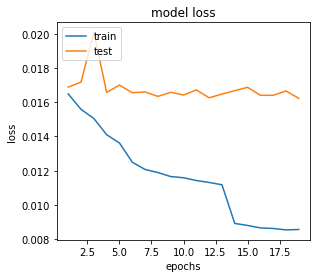

In [107]:
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(np.arange(1, len(testl) + 1), trainl)  # train loss (on epoch end)
plt.plot(np.arange(1, len(testl) + 1), testl)         #  test loss (on epoch end)
plt.title("model loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc="upper left")



In [110]:
fig.savefig('CNN3d.png')

In [122]:
i=1729

print(test_list[i])
print(preds[i])
print(test_label[i])

VuadgOz6T7s.004.mp4
[0.39640063 0.39109632 0.45095205 0.4061265  0.41558078 0.47275183]
[0.17757009 0.18691589 0.28571429 0.22330097 0.16666667 0.21111111]
